In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# path="/content/drive/MyDrive/Research/Hard_Attention/dataset_2/m_5_size_100/run_"

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/hard_attention')

# Generate dataset

In [5]:
np.random.seed(1)

y = np.concatenate((np.zeros(500),np.ones(500),np.ones(500)*2,np.ones(500)*3,np.ones(500)*4,
                    np.ones(500)*5,np.ones(500)*6,np.ones(500)*7,np.ones(500)*8,np.ones(500)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [6]:
x = np.zeros((5000,2))

In [7]:
x = np.zeros((5000,2))


np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [5,5],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [5.5,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [-1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [0,2],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [0,-1],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [0,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [-0.5,-0.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [0.4,0.2],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))

In [8]:
x[idx[0]][0], x[idx[2]][5] 

(array([5.14957125, 4.78451422]), array([5.59513544, 6.5252764 ]))

In [9]:
print(x.shape,y.shape)

(5000, 2) (5000,)


In [10]:
idx= []
for i in range(10):
  idx.append(y==i)

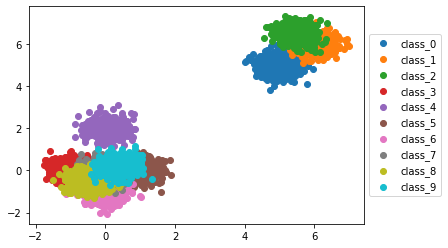

In [11]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
x = ( x -  np.mean(x,axis=0,keepdims=True) ) / np.std(x,axis=0,keepdims=True) 


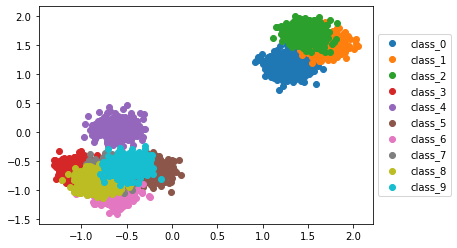

In [13]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [15]:
desired_num = 1500
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
m = 5
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|████████████████████████████████████| 1500/1500 [00:00<00:00, 11903.06it/s]


In [16]:
# mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [17]:
len(mosaic_list_of_images), mosaic_list_of_images[0],mosaic_list_of_images[0].shape

(1500,
 array([[ 1.29420953,  0.98948331],
        [-0.62723678, -1.08186056],
        [-0.85061921,  0.02673107],
        [-0.83096682, -0.93025336],
        [-0.94404393, -0.55234797]]),
 (5, 2))

In [18]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [19]:
batch = 50
msd1 = MosaicDataset(mosaic_list_of_images[0:500], mosaic_label[0:500] , fore_idx[0:500])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [20]:
data,_,_=iter(train_loader).next()

In [21]:
data.shape

torch.Size([50, 5, 2])

In [22]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[500:], mosaic_label[500:] , fore_idx[500:])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [23]:
class Focus(nn.Module):
    def __init__(self):
        super(Focus, self).__init__()
        self.fc1 = nn.Linear(2,1, bias=False)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        #self.fc2 = nn.Linear(64, 1, bias=False)
        #torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self,z):
        #print("data",z)
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,2*1)
        alp1,ft1 = self.helper(z)

        alpha = F.softmax(alp1,dim=1)
        #print(self.training)
        
        if self.training:
            alpha =alpha[:,:,0]
            y = ft1 
            return alpha,y
        else:
            #alpha_cumsum = torch.cumsum(alpha, dim = 1)
            #print(alpha_cumsum)
            #len_batch = alpha_cumsum.size(0)
            #patches = alpha_cumsum.size(1)
            #rand_prob = torch.rand(len_batch,patches, 1).to(device)
            #alpha_relu = F.relu(rand_prob-alpha_cumsum)
            #print(alpha_relu)
            #alpha_index = torch.count_nonzero(alpha_relu,dim=1)
            #alpha_hard = F.one_hot(alpha_index,num_classes=patches)
            #print(alpha_hard)
            #alpha_hard = torch.transpose(alpha_hard,dim0=1,dim1=2)
            #print(ft1,"alpha_hard",alpha_hard) 
            #y = torch.sum(alpha_hard*ft1,dim=1)
            #print(alpha,alpha.shape)
         
        
            index = torch.argmax(alpha,dim=1)
            hard_alpha = torch.nn.functional.one_hot(index[:,0], patches)
            y = torch.sum(hard_alpha[:,:,None]*ft1,dim=1)
            alpha = alpha[:,:,0]
            return alpha,y
    
    def helper(self, x):
        x1 = x
        x = self.fc1(x)
        return x,x1

In [24]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 3)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)

  def forward(self, x):
    #print(x.shape)
    #x = x.view(-1, 1)
    #print(x.shape)
    x = self.fc1(x)
    # print(x.shape)
    return x

In [38]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net = focus_net.to(device)

In [39]:
torch.manual_seed(12)
classify = Classification().double()
classify = classify.to(device)

In [40]:
import torch.optim as optim
optimizer_classify = optim.Adam(classify.parameters(), lr=0.1 ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.1 ) #, momentum=0.9)

In [41]:
def my_cross_entropy(output,target,alpha):
    criterion = nn.CrossEntropyLoss(reduce=False)
    
    batch = output.size(0)
    #print(batch)
    patches = output.size(1)
    classes = output.size(2)
    
    
    
    output = torch.reshape(output,(batch*patches,classes))
    
    
    target = target.repeat_interleave(patches)
    
    loss = criterion(output,target)
    
    #print(loss,loss.shape)
    loss = torch.reshape(loss,(batch,patches))
    #print(loss.size())
    final_loss = torch.sum(torch.mul(loss,alpha),dim=1)
    #print(final_loss.shape)
    final_loss = torch.mean(final_loss,dim=0)
    
    
    
    #print(final_loss)
    return final_loss
    
    
    

In [42]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [43]:
def plot_attended_data(trainloader,net,epoch):
    attd_data =[]
    lbls = []
    for data in trainloader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
        alphas, avg_images = focus_net(inputs)
        attd_data.append(avg_images.numpy())
        lbls.append(labels)
    attd_data = np.concatenate(attd_data,axis=0)
    lbls = np.concatenate(lbls,axis=0)
    plt.figure(figsize=(6,8))
    plt.scatter(attd_data[:,0],attd_data[:,1],c=lbls)
    plt.title("EPOCH_"+str(epoch))

In [44]:
correct = 0
total = 0
count = 0
flag = 1


with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    loss = my_cross_entropy(outputs,labels,alphas)
    print(loss)
    # print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1)


print("="*100)



tensor(1.1578, dtype=torch.float64)
tensor(1.1320, dtype=torch.float64)
tensor(1.1502, dtype=torch.float64)
tensor(1.1392, dtype=torch.float64)
tensor(1.1392, dtype=torch.float64)
tensor(1.1542, dtype=torch.float64)
tensor(1.1439, dtype=torch.float64)
tensor(1.1303, dtype=torch.float64)
tensor(1.1698, dtype=torch.float64)
tensor(1.1255, dtype=torch.float64)


In [45]:
correct = 0
total = 0
count = 0
flag = 1


with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)


In [46]:
for param in focus_net.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[-0.4664, -0.4478]], dtype=torch.float64, requires_grad=True))


In [47]:
nos_epochs = 2000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    batch = inputs.size(0)
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = my_cross_entropy(outputs, labels,alphas) 
    
    loss.backward()
    
    
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 2
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1

  if(np.mean(epoch_loss) <= 0.01):
      break;
  #plot_attended_data(train_loader,focus_net,epoch)

    
print('Finished Training')

[1,     2] loss: 1.119
[1,     4] loss: 1.124
[1,     6] loss: 1.126
[1,     8] loss: 1.176
[1,    10] loss: 1.113
[2,     2] loss: 1.120
[2,     4] loss: 1.124
[2,     6] loss: 1.118
[2,     8] loss: 1.106
[2,    10] loss: 1.114
[3,     2] loss: 1.109
[3,     4] loss: 1.122
[3,     6] loss: 1.096
[3,     8] loss: 1.099
[3,    10] loss: 1.106
[4,     2] loss: 1.102
[4,     4] loss: 1.113
[4,     6] loss: 1.105
[4,     8] loss: 1.111
[4,    10] loss: 1.117
[5,     2] loss: 1.105
[5,     4] loss: 1.101
[5,     6] loss: 1.104
[5,     8] loss: 1.104
[5,    10] loss: 1.109
[6,     2] loss: 1.098
[6,     4] loss: 1.134
[6,     6] loss: 1.117
[6,     8] loss: 1.098
[6,    10] loss: 1.106
[7,     2] loss: 1.109
[7,     4] loss: 1.101
[7,     6] loss: 1.103
[7,     8] loss: 1.089
[7,    10] loss: 1.060
[8,     2] loss: 1.062
[8,     4] loss: 1.077
[8,     6] loss: 1.066
[8,     8] loss: 1.026
[8,    10] loss: 1.080
[9,     2] loss: 1.018
[9,     4] loss: 1.004
[9,     6] loss: 1.042
[9,     8] 

[82,     4] loss: 0.364
[82,     6] loss: 0.344
[82,     8] loss: 0.419
[82,    10] loss: 0.311
[83,     2] loss: 0.390
[83,     4] loss: 0.348
[83,     6] loss: 0.310
[83,     8] loss: 0.283
[83,    10] loss: 0.396
[84,     2] loss: 0.380
[84,     4] loss: 0.323
[84,     6] loss: 0.330
[84,     8] loss: 0.321
[84,    10] loss: 0.358
[85,     2] loss: 0.345
[85,     4] loss: 0.397
[85,     6] loss: 0.318
[85,     8] loss: 0.373
[85,    10] loss: 0.289
[86,     2] loss: 0.339
[86,     4] loss: 0.315
[86,     6] loss: 0.310
[86,     8] loss: 0.388
[86,    10] loss: 0.369
[87,     2] loss: 0.355
[87,     4] loss: 0.378
[87,     6] loss: 0.354
[87,     8] loss: 0.391
[87,    10] loss: 0.250
[88,     2] loss: 0.344
[88,     4] loss: 0.316
[88,     6] loss: 0.318
[88,     8] loss: 0.354
[88,    10] loss: 0.360
[89,     2] loss: 0.320
[89,     4] loss: 0.384
[89,     6] loss: 0.344
[89,     8] loss: 0.336
[89,    10] loss: 0.333
[90,     2] loss: 0.318
[90,     4] loss: 0.289
[90,     6] loss

[148,     8] loss: 0.294
[148,    10] loss: 0.305
[149,     2] loss: 0.302
[149,     4] loss: 0.272
[149,     6] loss: 0.325
[149,     8] loss: 0.353
[149,    10] loss: 0.322
[150,     2] loss: 0.292
[150,     4] loss: 0.368
[150,     6] loss: 0.293
[150,     8] loss: 0.319
[150,    10] loss: 0.301
[151,     2] loss: 0.327
[151,     4] loss: 0.263
[151,     6] loss: 0.341
[151,     8] loss: 0.293
[151,    10] loss: 0.341
[152,     2] loss: 0.359
[152,     4] loss: 0.265
[152,     6] loss: 0.308
[152,     8] loss: 0.340
[152,    10] loss: 0.339
[153,     2] loss: 0.338
[153,     4] loss: 0.260
[153,     6] loss: 0.286
[153,     8] loss: 0.331
[153,    10] loss: 0.325
[154,     2] loss: 0.291
[154,     4] loss: 0.262
[154,     6] loss: 0.391
[154,     8] loss: 0.340
[154,    10] loss: 0.312
[155,     2] loss: 0.264
[155,     4] loss: 0.310
[155,     6] loss: 0.364
[155,     8] loss: 0.377
[155,    10] loss: 0.381
[156,     2] loss: 0.359
[156,     4] loss: 0.332
[156,     6] loss: 0.263


[243,     6] loss: 0.216
[243,     8] loss: 0.282
[243,    10] loss: 0.341
[244,     2] loss: 0.253
[244,     4] loss: 0.278
[244,     6] loss: 0.299
[244,     8] loss: 0.402
[244,    10] loss: 0.241
[245,     2] loss: 0.336
[245,     4] loss: 0.260
[245,     6] loss: 0.311
[245,     8] loss: 0.333
[245,    10] loss: 0.255
[246,     2] loss: 0.352
[246,     4] loss: 0.289
[246,     6] loss: 0.276
[246,     8] loss: 0.292
[246,    10] loss: 0.269
[247,     2] loss: 0.401
[247,     4] loss: 0.261
[247,     6] loss: 0.333
[247,     8] loss: 0.219
[247,    10] loss: 0.269
[248,     2] loss: 0.352
[248,     4] loss: 0.248
[248,     6] loss: 0.281
[248,     8] loss: 0.275
[248,    10] loss: 0.317
[249,     2] loss: 0.316
[249,     4] loss: 0.293
[249,     6] loss: 0.276
[249,     8] loss: 0.273
[249,    10] loss: 0.304
[250,     2] loss: 0.354
[250,     4] loss: 0.317
[250,     6] loss: 0.182
[250,     8] loss: 0.258
[250,    10] loss: 0.353
[251,     2] loss: 0.289
[251,     4] loss: 0.246


[341,     8] loss: 0.293
[341,    10] loss: 0.289
[342,     2] loss: 0.322
[342,     4] loss: 0.301
[342,     6] loss: 0.178
[342,     8] loss: 0.311
[342,    10] loss: 0.337
[343,     2] loss: 0.343
[343,     4] loss: 0.198
[343,     6] loss: 0.258
[343,     8] loss: 0.297
[343,    10] loss: 0.354
[344,     2] loss: 0.309
[344,     4] loss: 0.320
[344,     6] loss: 0.356
[344,     8] loss: 0.274
[344,    10] loss: 0.207
[345,     2] loss: 0.268
[345,     4] loss: 0.289
[345,     6] loss: 0.287
[345,     8] loss: 0.301
[345,    10] loss: 0.315
[346,     2] loss: 0.349
[346,     4] loss: 0.338
[346,     6] loss: 0.220
[346,     8] loss: 0.261
[346,    10] loss: 0.268
[347,     2] loss: 0.293
[347,     4] loss: 0.202
[347,     6] loss: 0.294
[347,     8] loss: 0.312
[347,    10] loss: 0.330
[348,     2] loss: 0.272
[348,     4] loss: 0.195
[348,     6] loss: 0.365
[348,     8] loss: 0.336
[348,    10] loss: 0.258
[349,     2] loss: 0.344
[349,     4] loss: 0.412
[349,     6] loss: 0.270


[441,     2] loss: 0.305
[441,     4] loss: 0.290
[441,     6] loss: 0.241
[441,     8] loss: 0.266
[441,    10] loss: 0.326
[442,     2] loss: 0.236
[442,     4] loss: 0.288
[442,     6] loss: 0.311
[442,     8] loss: 0.364
[442,    10] loss: 0.219
[443,     2] loss: 0.206
[443,     4] loss: 0.310
[443,     6] loss: 0.343
[443,     8] loss: 0.270
[443,    10] loss: 0.304
[444,     2] loss: 0.260
[444,     4] loss: 0.271
[444,     6] loss: 0.327
[444,     8] loss: 0.269
[444,    10] loss: 0.294
[445,     2] loss: 0.282
[445,     4] loss: 0.268
[445,     6] loss: 0.219
[445,     8] loss: 0.241
[445,    10] loss: 0.412
[446,     2] loss: 0.257
[446,     4] loss: 0.283
[446,     6] loss: 0.287
[446,     8] loss: 0.276
[446,    10] loss: 0.300
[447,     2] loss: 0.255
[447,     4] loss: 0.331
[447,     6] loss: 0.233
[447,     8] loss: 0.325
[447,    10] loss: 0.277
[448,     2] loss: 0.337
[448,     4] loss: 0.306
[448,     6] loss: 0.276
[448,     8] loss: 0.224
[448,    10] loss: 0.287


[539,     8] loss: 0.379
[539,    10] loss: 0.339
[540,     2] loss: 0.342
[540,     4] loss: 0.309
[540,     6] loss: 0.248
[540,     8] loss: 0.291
[540,    10] loss: 0.326
[541,     2] loss: 0.323
[541,     4] loss: 0.310
[541,     6] loss: 0.192
[541,     8] loss: 0.362
[541,    10] loss: 0.241
[542,     2] loss: 0.251
[542,     4] loss: 0.282
[542,     6] loss: 0.249
[542,     8] loss: 0.286
[542,    10] loss: 0.308
[543,     2] loss: 0.236
[543,     4] loss: 0.402
[543,     6] loss: 0.250
[543,     8] loss: 0.276
[543,    10] loss: 0.252
[544,     2] loss: 0.334
[544,     4] loss: 0.302
[544,     6] loss: 0.243
[544,     8] loss: 0.308
[544,    10] loss: 0.271
[545,     2] loss: 0.252
[545,     4] loss: 0.266
[545,     6] loss: 0.268
[545,     8] loss: 0.354
[545,    10] loss: 0.254
[546,     2] loss: 0.250
[546,     4] loss: 0.268
[546,     6] loss: 0.313
[546,     8] loss: 0.278
[546,    10] loss: 0.344
[547,     2] loss: 0.276
[547,     4] loss: 0.294
[547,     6] loss: 0.276


[607,    10] loss: 0.332
[608,     2] loss: 0.324
[608,     4] loss: 0.307
[608,     6] loss: 0.268
[608,     8] loss: 0.261
[608,    10] loss: 0.236
[609,     2] loss: 0.263
[609,     4] loss: 0.279
[609,     6] loss: 0.360
[609,     8] loss: 0.306
[609,    10] loss: 0.207
[610,     2] loss: 0.313
[610,     4] loss: 0.333
[610,     6] loss: 0.234
[610,     8] loss: 0.238
[610,    10] loss: 0.286
[611,     2] loss: 0.269
[611,     4] loss: 0.310
[611,     6] loss: 0.239
[611,     8] loss: 0.287
[611,    10] loss: 0.359
[612,     2] loss: 0.265
[612,     4] loss: 0.299
[612,     6] loss: 0.233
[612,     8] loss: 0.332
[612,    10] loss: 0.304
[613,     2] loss: 0.259
[613,     4] loss: 0.271
[613,     6] loss: 0.340
[613,     8] loss: 0.244
[613,    10] loss: 0.289
[614,     2] loss: 0.342
[614,     4] loss: 0.277
[614,     6] loss: 0.250
[614,     8] loss: 0.275
[614,    10] loss: 0.257
[615,     2] loss: 0.255
[615,     4] loss: 0.296
[615,     6] loss: 0.326
[615,     8] loss: 0.263


[704,     2] loss: 0.197
[704,     4] loss: 0.297
[704,     6] loss: 0.303
[704,     8] loss: 0.267
[704,    10] loss: 0.324
[705,     2] loss: 0.298
[705,     4] loss: 0.308
[705,     6] loss: 0.243
[705,     8] loss: 0.270
[705,    10] loss: 0.272
[706,     2] loss: 0.259
[706,     4] loss: 0.254
[706,     6] loss: 0.296
[706,     8] loss: 0.298
[706,    10] loss: 0.277
[707,     2] loss: 0.252
[707,     4] loss: 0.407
[707,     6] loss: 0.255
[707,     8] loss: 0.229
[707,    10] loss: 0.251
[708,     2] loss: 0.274
[708,     4] loss: 0.233
[708,     6] loss: 0.347
[708,     8] loss: 0.327
[708,    10] loss: 0.242
[709,     2] loss: 0.341
[709,     4] loss: 0.334
[709,     6] loss: 0.308
[709,     8] loss: 0.211
[709,    10] loss: 0.323
[710,     2] loss: 0.217
[710,     4] loss: 0.201
[710,     6] loss: 0.284
[710,     8] loss: 0.274
[710,    10] loss: 0.413
[711,     2] loss: 0.267
[711,     4] loss: 0.329
[711,     6] loss: 0.235
[711,     8] loss: 0.325
[711,    10] loss: 0.232


[771,     6] loss: 0.362
[771,     8] loss: 0.273
[771,    10] loss: 0.213
[772,     2] loss: 0.339
[772,     4] loss: 0.300
[772,     6] loss: 0.219
[772,     8] loss: 0.247
[772,    10] loss: 0.312
[773,     2] loss: 0.272
[773,     4] loss: 0.310
[773,     6] loss: 0.383
[773,     8] loss: 0.254
[773,    10] loss: 0.224
[774,     2] loss: 0.283
[774,     4] loss: 0.299
[774,     6] loss: 0.286
[774,     8] loss: 0.266
[774,    10] loss: 0.342
[775,     2] loss: 0.302
[775,     4] loss: 0.262
[775,     6] loss: 0.233
[775,     8] loss: 0.335
[775,    10] loss: 0.250
[776,     2] loss: 0.331
[776,     4] loss: 0.285
[776,     6] loss: 0.268
[776,     8] loss: 0.246
[776,    10] loss: 0.255
[777,     2] loss: 0.320
[777,     4] loss: 0.254
[777,     6] loss: 0.317
[777,     8] loss: 0.266
[777,    10] loss: 0.230
[778,     2] loss: 0.254
[778,     4] loss: 0.389
[778,     6] loss: 0.291
[778,     8] loss: 0.231
[778,    10] loss: 0.250
[779,     2] loss: 0.259
[779,     4] loss: 0.291


[837,     2] loss: 0.221
[837,     4] loss: 0.289
[837,     6] loss: 0.243
[837,     8] loss: 0.335
[837,    10] loss: 0.292
[838,     2] loss: 0.316
[838,     4] loss: 0.344
[838,     6] loss: 0.266
[838,     8] loss: 0.297
[838,    10] loss: 0.213
[839,     2] loss: 0.284
[839,     4] loss: 0.223
[839,     6] loss: 0.398
[839,     8] loss: 0.263
[839,    10] loss: 0.270
[840,     2] loss: 0.253
[840,     4] loss: 0.321
[840,     6] loss: 0.318
[840,     8] loss: 0.275
[840,    10] loss: 0.289
[841,     2] loss: 0.272
[841,     4] loss: 0.251
[841,     6] loss: 0.306
[841,     8] loss: 0.309
[841,    10] loss: 0.266
[842,     2] loss: 0.278
[842,     4] loss: 0.251
[842,     6] loss: 0.286
[842,     8] loss: 0.235
[842,    10] loss: 0.370
[843,     2] loss: 0.292
[843,     4] loss: 0.230
[843,     6] loss: 0.227
[843,     8] loss: 0.427
[843,    10] loss: 0.218
[844,     2] loss: 0.262
[844,     4] loss: 0.231
[844,     6] loss: 0.322
[844,     8] loss: 0.303
[844,    10] loss: 0.270


[936,    10] loss: 0.295
[937,     2] loss: 0.250
[937,     4] loss: 0.277
[937,     6] loss: 0.225
[937,     8] loss: 0.254
[937,    10] loss: 0.377
[938,     2] loss: 0.250
[938,     4] loss: 0.320
[938,     6] loss: 0.295
[938,     8] loss: 0.256
[938,    10] loss: 0.261
[939,     2] loss: 0.264
[939,     4] loss: 0.280
[939,     6] loss: 0.326
[939,     8] loss: 0.269
[939,    10] loss: 0.271
[940,     2] loss: 0.311
[940,     4] loss: 0.308
[940,     6] loss: 0.198
[940,     8] loss: 0.337
[940,    10] loss: 0.268
[941,     2] loss: 0.236
[941,     4] loss: 0.271
[941,     6] loss: 0.223
[941,     8] loss: 0.378
[941,    10] loss: 0.265
[942,     2] loss: 0.250
[942,     4] loss: 0.406
[942,     6] loss: 0.185
[942,     8] loss: 0.220
[942,    10] loss: 0.375
[943,     2] loss: 0.252
[943,     4] loss: 0.324
[943,     6] loss: 0.315
[943,     8] loss: 0.246
[943,    10] loss: 0.255
[944,     2] loss: 0.299
[944,     4] loss: 0.307
[944,     6] loss: 0.346
[944,     8] loss: 0.208


[1004,     8] loss: 0.301
[1004,    10] loss: 0.280
[1005,     2] loss: 0.291
[1005,     4] loss: 0.233
[1005,     6] loss: 0.190
[1005,     8] loss: 0.298
[1005,    10] loss: 0.362
[1006,     2] loss: 0.253
[1006,     4] loss: 0.308
[1006,     6] loss: 0.239
[1006,     8] loss: 0.282
[1006,    10] loss: 0.294
[1007,     2] loss: 0.159
[1007,     4] loss: 0.348
[1007,     6] loss: 0.297
[1007,     8] loss: 0.289
[1007,    10] loss: 0.305
[1008,     2] loss: 0.200
[1008,     4] loss: 0.292
[1008,     6] loss: 0.285
[1008,     8] loss: 0.282
[1008,    10] loss: 0.324
[1009,     2] loss: 0.249
[1009,     4] loss: 0.262
[1009,     6] loss: 0.303
[1009,     8] loss: 0.310
[1009,    10] loss: 0.249
[1010,     2] loss: 0.210
[1010,     4] loss: 0.208
[1010,     6] loss: 0.256
[1010,     8] loss: 0.378
[1010,    10] loss: 0.327
[1011,     2] loss: 0.293
[1011,     4] loss: 0.220
[1011,     6] loss: 0.255
[1011,     8] loss: 0.258
[1011,    10] loss: 0.357
[1012,     2] loss: 0.283
[1012,     4

[1069,     4] loss: 0.266
[1069,     6] loss: 0.220
[1069,     8] loss: 0.247
[1069,    10] loss: 0.301
[1070,     2] loss: 0.228
[1070,     4] loss: 0.298
[1070,     6] loss: 0.308
[1070,     8] loss: 0.301
[1070,    10] loss: 0.253
[1071,     2] loss: 0.321
[1071,     4] loss: 0.302
[1071,     6] loss: 0.290
[1071,     8] loss: 0.248
[1071,    10] loss: 0.229
[1072,     2] loss: 0.278
[1072,     4] loss: 0.287
[1072,     6] loss: 0.277
[1072,     8] loss: 0.213
[1072,    10] loss: 0.326
[1073,     2] loss: 0.251
[1073,     4] loss: 0.265
[1073,     6] loss: 0.295
[1073,     8] loss: 0.277
[1073,    10] loss: 0.299
[1074,     2] loss: 0.218
[1074,     4] loss: 0.255
[1074,     6] loss: 0.239
[1074,     8] loss: 0.397
[1074,    10] loss: 0.289
[1075,     2] loss: 0.290
[1075,     4] loss: 0.268
[1075,     6] loss: 0.315
[1075,     8] loss: 0.218
[1075,    10] loss: 0.319
[1076,     2] loss: 0.236
[1076,     4] loss: 0.252
[1076,     6] loss: 0.228
[1076,     8] loss: 0.255
[1076,    10

[1140,     4] loss: 0.252
[1140,     6] loss: 0.244
[1140,     8] loss: 0.331
[1140,    10] loss: 0.237
[1141,     2] loss: 0.302
[1141,     4] loss: 0.292
[1141,     6] loss: 0.215
[1141,     8] loss: 0.331
[1141,    10] loss: 0.225
[1142,     2] loss: 0.189
[1142,     4] loss: 0.309
[1142,     6] loss: 0.224
[1142,     8] loss: 0.318
[1142,    10] loss: 0.331
[1143,     2] loss: 0.262
[1143,     4] loss: 0.329
[1143,     6] loss: 0.214
[1143,     8] loss: 0.270
[1143,    10] loss: 0.287
[1144,     2] loss: 0.251
[1144,     4] loss: 0.296
[1144,     6] loss: 0.217
[1144,     8] loss: 0.279
[1144,    10] loss: 0.339
[1145,     2] loss: 0.344
[1145,     4] loss: 0.242
[1145,     6] loss: 0.237
[1145,     8] loss: 0.256
[1145,    10] loss: 0.291
[1146,     2] loss: 0.301
[1146,     4] loss: 0.276
[1146,     6] loss: 0.239
[1146,     8] loss: 0.216
[1146,    10] loss: 0.377
[1147,     2] loss: 0.304
[1147,     4] loss: 0.298
[1147,     6] loss: 0.233
[1147,     8] loss: 0.345
[1147,    10

[1206,    10] loss: 0.279
[1207,     2] loss: 0.269
[1207,     4] loss: 0.243
[1207,     6] loss: 0.320
[1207,     8] loss: 0.306
[1207,    10] loss: 0.249
[1208,     2] loss: 0.217
[1208,     4] loss: 0.290
[1208,     6] loss: 0.230
[1208,     8] loss: 0.340
[1208,    10] loss: 0.302
[1209,     2] loss: 0.219
[1209,     4] loss: 0.267
[1209,     6] loss: 0.397
[1209,     8] loss: 0.293
[1209,    10] loss: 0.204
[1210,     2] loss: 0.287
[1210,     4] loss: 0.303
[1210,     6] loss: 0.239
[1210,     8] loss: 0.287
[1210,    10] loss: 0.290
[1211,     2] loss: 0.209
[1211,     4] loss: 0.326
[1211,     6] loss: 0.360
[1211,     8] loss: 0.255
[1211,    10] loss: 0.237
[1212,     2] loss: 0.256
[1212,     4] loss: 0.299
[1212,     6] loss: 0.322
[1212,     8] loss: 0.220
[1212,    10] loss: 0.269
[1213,     2] loss: 0.368
[1213,     4] loss: 0.203
[1213,     6] loss: 0.228
[1213,     8] loss: 0.313
[1213,    10] loss: 0.250
[1214,     2] loss: 0.297
[1214,     4] loss: 0.277
[1214,     6

[1295,     8] loss: 0.164
[1295,    10] loss: 0.348
[1296,     2] loss: 0.355
[1296,     4] loss: 0.271
[1296,     6] loss: 0.305
[1296,     8] loss: 0.267
[1296,    10] loss: 0.205
[1297,     2] loss: 0.207
[1297,     4] loss: 0.259
[1297,     6] loss: 0.277
[1297,     8] loss: 0.325
[1297,    10] loss: 0.292
[1298,     2] loss: 0.245
[1298,     4] loss: 0.294
[1298,     6] loss: 0.241
[1298,     8] loss: 0.257
[1298,    10] loss: 0.348
[1299,     2] loss: 0.258
[1299,     4] loss: 0.331
[1299,     6] loss: 0.252
[1299,     8] loss: 0.299
[1299,    10] loss: 0.229
[1300,     2] loss: 0.249
[1300,     4] loss: 0.334
[1300,     6] loss: 0.208
[1300,     8] loss: 0.225
[1300,    10] loss: 0.397
[1301,     2] loss: 0.270
[1301,     4] loss: 0.328
[1301,     6] loss: 0.185
[1301,     8] loss: 0.222
[1301,    10] loss: 0.387
[1302,     2] loss: 0.264
[1302,     4] loss: 0.336
[1302,     6] loss: 0.257
[1302,     8] loss: 0.307
[1302,    10] loss: 0.220
[1303,     2] loss: 0.301
[1303,     4

[1360,    10] loss: 0.289
[1361,     2] loss: 0.311
[1361,     4] loss: 0.248
[1361,     6] loss: 0.281
[1361,     8] loss: 0.263
[1361,    10] loss: 0.258
[1362,     2] loss: 0.268
[1362,     4] loss: 0.332
[1362,     6] loss: 0.310
[1362,     8] loss: 0.201
[1362,    10] loss: 0.271
[1363,     2] loss: 0.289
[1363,     4] loss: 0.279
[1363,     6] loss: 0.316
[1363,     8] loss: 0.244
[1363,    10] loss: 0.252
[1364,     2] loss: 0.306
[1364,     4] loss: 0.275
[1364,     6] loss: 0.192
[1364,     8] loss: 0.336
[1364,    10] loss: 0.276
[1365,     2] loss: 0.256
[1365,     4] loss: 0.228
[1365,     6] loss: 0.320
[1365,     8] loss: 0.251
[1365,    10] loss: 0.324
[1366,     2] loss: 0.262
[1366,     4] loss: 0.331
[1366,     6] loss: 0.268
[1366,     8] loss: 0.303
[1366,    10] loss: 0.215
[1367,     2] loss: 0.219
[1367,     4] loss: 0.362
[1367,     6] loss: 0.215
[1367,     8] loss: 0.282
[1367,    10] loss: 0.290
[1368,     2] loss: 0.326
[1368,     4] loss: 0.276
[1368,     6

[1428,     2] loss: 0.273
[1428,     4] loss: 0.319
[1428,     6] loss: 0.198
[1428,     8] loss: 0.264
[1428,    10] loss: 0.349
[1429,     2] loss: 0.195
[1429,     4] loss: 0.366
[1429,     6] loss: 0.291
[1429,     8] loss: 0.298
[1429,    10] loss: 0.264
[1430,     2] loss: 0.299
[1430,     4] loss: 0.289
[1430,     6] loss: 0.264
[1430,     8] loss: 0.283
[1430,    10] loss: 0.273
[1431,     2] loss: 0.292
[1431,     4] loss: 0.225
[1431,     6] loss: 0.298
[1431,     8] loss: 0.373
[1431,    10] loss: 0.231
[1432,     2] loss: 0.386
[1432,     4] loss: 0.219
[1432,     6] loss: 0.206
[1432,     8] loss: 0.356
[1432,    10] loss: 0.219
[1433,     2] loss: 0.336
[1433,     4] loss: 0.286
[1433,     6] loss: 0.295
[1433,     8] loss: 0.239
[1433,    10] loss: 0.259
[1434,     2] loss: 0.330
[1434,     4] loss: 0.215
[1434,     6] loss: 0.282
[1434,     8] loss: 0.296
[1434,    10] loss: 0.241
[1435,     2] loss: 0.317
[1435,     4] loss: 0.266
[1435,     6] loss: 0.222
[1435,     8

[1493,     6] loss: 0.328
[1493,     8] loss: 0.281
[1493,    10] loss: 0.295
[1494,     2] loss: 0.297
[1494,     4] loss: 0.277
[1494,     6] loss: 0.350
[1494,     8] loss: 0.203
[1494,    10] loss: 0.275
[1495,     2] loss: 0.247
[1495,     4] loss: 0.260
[1495,     6] loss: 0.334
[1495,     8] loss: 0.292
[1495,    10] loss: 0.289
[1496,     2] loss: 0.273
[1496,     4] loss: 0.315
[1496,     6] loss: 0.260
[1496,     8] loss: 0.301
[1496,    10] loss: 0.236
[1497,     2] loss: 0.291
[1497,     4] loss: 0.191
[1497,     6] loss: 0.306
[1497,     8] loss: 0.279
[1497,    10] loss: 0.316
[1498,     2] loss: 0.328
[1498,     4] loss: 0.239
[1498,     6] loss: 0.195
[1498,     8] loss: 0.295
[1498,    10] loss: 0.296
[1499,     2] loss: 0.322
[1499,     4] loss: 0.257
[1499,     6] loss: 0.263
[1499,     8] loss: 0.322
[1499,    10] loss: 0.196
[1500,     2] loss: 0.292
[1500,     4] loss: 0.237
[1500,     6] loss: 0.240
[1500,     8] loss: 0.292
[1500,    10] loss: 0.328
[1501,     2

[1557,     6] loss: 0.320
[1557,     8] loss: 0.272
[1557,    10] loss: 0.234
[1558,     2] loss: 0.332
[1558,     4] loss: 0.241
[1558,     6] loss: 0.258
[1558,     8] loss: 0.275
[1558,    10] loss: 0.263
[1559,     2] loss: 0.260
[1559,     4] loss: 0.271
[1559,     6] loss: 0.335
[1559,     8] loss: 0.218
[1559,    10] loss: 0.283
[1560,     2] loss: 0.252
[1560,     4] loss: 0.296
[1560,     6] loss: 0.279
[1560,     8] loss: 0.266
[1560,    10] loss: 0.301
[1561,     2] loss: 0.220
[1561,     4] loss: 0.358
[1561,     6] loss: 0.335
[1561,     8] loss: 0.279
[1561,    10] loss: 0.242
[1562,     2] loss: 0.225
[1562,     4] loss: 0.296
[1562,     6] loss: 0.286
[1562,     8] loss: 0.273
[1562,    10] loss: 0.297
[1563,     2] loss: 0.291
[1563,     4] loss: 0.249
[1563,     6] loss: 0.339
[1563,     8] loss: 0.232
[1563,    10] loss: 0.271
[1564,     2] loss: 0.227
[1564,     4] loss: 0.254
[1564,     6] loss: 0.277
[1564,     8] loss: 0.303
[1564,    10] loss: 0.307
[1565,     2

[1624,     2] loss: 0.280
[1624,     4] loss: 0.261
[1624,     6] loss: 0.246
[1624,     8] loss: 0.309
[1624,    10] loss: 0.319
[1625,     2] loss: 0.252
[1625,     4] loss: 0.243
[1625,     6] loss: 0.188
[1625,     8] loss: 0.407
[1625,    10] loss: 0.258
[1626,     2] loss: 0.221
[1626,     4] loss: 0.291
[1626,     6] loss: 0.239
[1626,     8] loss: 0.334
[1626,    10] loss: 0.295
[1627,     2] loss: 0.253
[1627,     4] loss: 0.258
[1627,     6] loss: 0.322
[1627,     8] loss: 0.261
[1627,    10] loss: 0.279
[1628,     2] loss: 0.299
[1628,     4] loss: 0.212
[1628,     6] loss: 0.220
[1628,     8] loss: 0.351
[1628,    10] loss: 0.331
[1629,     2] loss: 0.255
[1629,     4] loss: 0.247
[1629,     6] loss: 0.363
[1629,     8] loss: 0.197
[1629,    10] loss: 0.324
[1630,     2] loss: 0.253
[1630,     4] loss: 0.290
[1630,     6] loss: 0.326
[1630,     8] loss: 0.277
[1630,    10] loss: 0.252
[1631,     2] loss: 0.237
[1631,     4] loss: 0.278
[1631,     6] loss: 0.341
[1631,     8

[1689,     8] loss: 0.182
[1689,    10] loss: 0.296
[1690,     2] loss: 0.199
[1690,     4] loss: 0.345
[1690,     6] loss: 0.330
[1690,     8] loss: 0.266
[1690,    10] loss: 0.226
[1691,     2] loss: 0.320
[1691,     4] loss: 0.231
[1691,     6] loss: 0.255
[1691,     8] loss: 0.249
[1691,    10] loss: 0.309
[1692,     2] loss: 0.285
[1692,     4] loss: 0.315
[1692,     6] loss: 0.292
[1692,     8] loss: 0.322
[1692,    10] loss: 0.269
[1693,     2] loss: 0.249
[1693,     4] loss: 0.315
[1693,     6] loss: 0.243
[1693,     8] loss: 0.353
[1693,    10] loss: 0.261
[1694,     2] loss: 0.234
[1694,     4] loss: 0.321
[1694,     6] loss: 0.288
[1694,     8] loss: 0.243
[1694,    10] loss: 0.280
[1695,     2] loss: 0.261
[1695,     4] loss: 0.268
[1695,     6] loss: 0.248
[1695,     8] loss: 0.299
[1695,    10] loss: 0.279
[1696,     2] loss: 0.281
[1696,     4] loss: 0.267
[1696,     6] loss: 0.406
[1696,     8] loss: 0.219
[1696,    10] loss: 0.247
[1697,     2] loss: 0.280
[1697,     4

[1756,    10] loss: 0.314
[1757,     2] loss: 0.315
[1757,     4] loss: 0.262
[1757,     6] loss: 0.287
[1757,     8] loss: 0.343
[1757,    10] loss: 0.170
[1758,     2] loss: 0.311
[1758,     4] loss: 0.245
[1758,     6] loss: 0.297
[1758,     8] loss: 0.262
[1758,    10] loss: 0.302
[1759,     2] loss: 0.325
[1759,     4] loss: 0.363
[1759,     6] loss: 0.178
[1759,     8] loss: 0.246
[1759,    10] loss: 0.294
[1760,     2] loss: 0.365
[1760,     4] loss: 0.264
[1760,     6] loss: 0.243
[1760,     8] loss: 0.222
[1760,    10] loss: 0.288
[1761,     2] loss: 0.295
[1761,     4] loss: 0.326
[1761,     6] loss: 0.280
[1761,     8] loss: 0.275
[1761,    10] loss: 0.179
[1762,     2] loss: 0.263
[1762,     4] loss: 0.199
[1762,     6] loss: 0.349
[1762,     8] loss: 0.250
[1762,    10] loss: 0.315
[1763,     2] loss: 0.353
[1763,     4] loss: 0.303
[1763,     6] loss: 0.265
[1763,     8] loss: 0.233
[1763,    10] loss: 0.268
[1764,     2] loss: 0.362
[1764,     4] loss: 0.246
[1764,     6

[1822,     2] loss: 0.395
[1822,     4] loss: 0.220
[1822,     6] loss: 0.317
[1822,     8] loss: 0.235
[1822,    10] loss: 0.241
[1823,     2] loss: 0.301
[1823,     4] loss: 0.236
[1823,     6] loss: 0.348
[1823,     8] loss: 0.259
[1823,    10] loss: 0.237
[1824,     2] loss: 0.304
[1824,     4] loss: 0.212
[1824,     6] loss: 0.272
[1824,     8] loss: 0.290
[1824,    10] loss: 0.285
[1825,     2] loss: 0.296
[1825,     4] loss: 0.269
[1825,     6] loss: 0.317
[1825,     8] loss: 0.244
[1825,    10] loss: 0.256
[1826,     2] loss: 0.294
[1826,     4] loss: 0.338
[1826,     6] loss: 0.283
[1826,     8] loss: 0.187
[1826,    10] loss: 0.266
[1827,     2] loss: 0.274
[1827,     4] loss: 0.268
[1827,     6] loss: 0.205
[1827,     8] loss: 0.295
[1827,    10] loss: 0.322
[1828,     2] loss: 0.254
[1828,     4] loss: 0.309
[1828,     6] loss: 0.224
[1828,     8] loss: 0.232
[1828,    10] loss: 0.379
[1829,     2] loss: 0.291
[1829,     4] loss: 0.199
[1829,     6] loss: 0.288
[1829,     8

[1888,     2] loss: 0.247
[1888,     4] loss: 0.338
[1888,     6] loss: 0.326
[1888,     8] loss: 0.260
[1888,    10] loss: 0.263
[1889,     2] loss: 0.365
[1889,     4] loss: 0.204
[1889,     6] loss: 0.262
[1889,     8] loss: 0.223
[1889,    10] loss: 0.305
[1890,     2] loss: 0.225
[1890,     4] loss: 0.406
[1890,     6] loss: 0.300
[1890,     8] loss: 0.244
[1890,    10] loss: 0.283
[1891,     2] loss: 0.346
[1891,     4] loss: 0.302
[1891,     6] loss: 0.281
[1891,     8] loss: 0.324
[1891,    10] loss: 0.231
[1892,     2] loss: 0.227
[1892,     4] loss: 0.266
[1892,     6] loss: 0.236
[1892,     8] loss: 0.389
[1892,    10] loss: 0.241
[1893,     2] loss: 0.224
[1893,     4] loss: 0.325
[1893,     6] loss: 0.229
[1893,     8] loss: 0.267
[1893,    10] loss: 0.306
[1894,     2] loss: 0.253
[1894,     4] loss: 0.223
[1894,     6] loss: 0.263
[1894,     8] loss: 0.329
[1894,    10] loss: 0.297
[1895,     2] loss: 0.265
[1895,     4] loss: 0.226
[1895,     6] loss: 0.287
[1895,     8

[1956,    10] loss: 0.241
[1957,     2] loss: 0.268
[1957,     4] loss: 0.332
[1957,     6] loss: 0.317
[1957,     8] loss: 0.199
[1957,    10] loss: 0.257
[1958,     2] loss: 0.218
[1958,     4] loss: 0.299
[1958,     6] loss: 0.207
[1958,     8] loss: 0.339
[1958,    10] loss: 0.285
[1959,     2] loss: 0.365
[1959,     4] loss: 0.159
[1959,     6] loss: 0.260
[1959,     8] loss: 0.290
[1959,    10] loss: 0.333
[1960,     2] loss: 0.201
[1960,     4] loss: 0.363
[1960,     6] loss: 0.299
[1960,     8] loss: 0.271
[1960,    10] loss: 0.257
[1961,     2] loss: 0.187
[1961,     4] loss: 0.317
[1961,     6] loss: 0.279
[1961,     8] loss: 0.265
[1961,    10] loss: 0.351
[1962,     2] loss: 0.155
[1962,     4] loss: 0.233
[1962,     6] loss: 0.325
[1962,     8] loss: 0.305
[1962,    10] loss: 0.339
[1963,     2] loss: 0.340
[1963,     4] loss: 0.291
[1963,     6] loss: 0.198
[1963,     8] loss: 0.233
[1963,    10] loss: 0.295
[1964,     2] loss: 0.296
[1964,     4] loss: 0.280
[1964,     6

In [48]:
for param in focus_net.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[7.3807, 7.3838]], dtype=torch.float64, requires_grad=True))


In [49]:
correct = 0
total = 0

focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to(device), labels.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    #print(outputs.shape)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the train images: 85.400000 %
total correct 427
total train set images 500


In [50]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to(device), labels.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the test images: 89.000000 %
total correct 890
total train set images 1000
